# Exploratory Data Analysis in European Soccer Leagues with SQLite3

## The objective of this project is to provide some random insights using SQL queries and making good visualizations with data

This database contains 8 different tables with the following features

 - +25,000 matches
 - +10,000 players
 - 11 European Countries with their lead championship
 - Seasons 2008 to 2016 
 - Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
 - Team line up with squad formation (X, Y coordinates)
 - Betting odds from up to 10 providers
 - Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

In [1]:
#Imports 

import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#create a path to the db
path = "database.sqlite"

connection = sqlite3.connect(path)

query = lambda x: pd.read_sql_query(x, connection)

## First, what tables are in this dataset? What Leagues? What Seasons? Let's take a look.

In [3]:
#Pull all tables from the schema
query('''
SELECT * FROM sqlite_schema WHERE type= 'table' 
''')

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
#Test by calling one table (League)
query('''
        SELECT *
        FROM league
        ''')

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
query('''
SELECT DISTINCT season FROM MATCH
''')

,season
0,2008/2009
1,2009/2010
2,2010/2011
3,2011/2012
4,2012/2013
5,2013/2014
6,2014/2015
7,2015/2016


## Queries

## 1- Determine the total and average number of matches played a in each league by each country for the entire period

In [8]:
query('''
        SELECT c.name country, l.name league, COUNT(match_api_id) matches_played
        FROM match m
        JOIN country c
        ON c.id = m.country_id
        JOIN league l
        ON l.country_id = c.id
        GROUP BY league
        ORDER BY matches_played DESC
        ''')

,country,league,matches_played
0,England,England Premier League,3040
1,France,France Ligue 1,3040
2,Spain,Spain LIGA BBVA,3040
3,Italy,Italy Serie A,3017
4,Germany,Germany 1. Bundesliga,2448
5,Netherlands,Netherlands Eredivisie,2448
6,Portugal,Portugal Liga ZON Sagres,2052
7,Poland,Poland Ekstraklasa,1920
8,Scotland,Scotland Premier League,1824
9,Belgium,Belgium Jupiler League,1728


In [ ]:
## 2- Determine the average number of matches played per year by country

In [6]:
coun = query('''
sELECT country, AVG(matches) avg
FROM   (SELECT country, year, COUNT(match_api_id) matches
        FROM    (SELECT SUBSTRING(m.date, 1, 4) year, m.match_api_id, c.name country
                FROM match m
                JOIN country c
        ON c.id = m.country_id) y
        GROUP BY country, year) x
GROUP BY country
ORDER BY avg DESC
            
        ''')

coun

,country,avg
0,Spain,337.777778
1,France,337.777778
2,England,337.777778
3,Italy,335.222222
4,Netherlands,272.000000
5,Germany,272.000000
6,Portugal,228.000000
7,Poland,213.333333
8,Scotland,202.666667
9,Belgium,192.000000


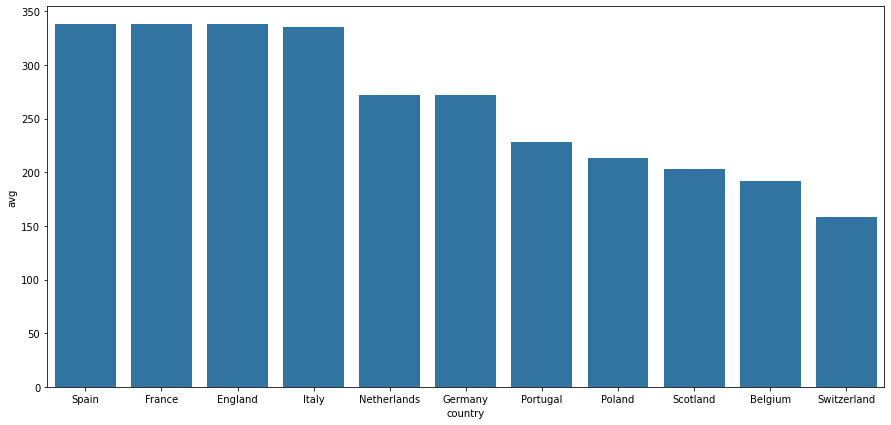

In [9]:
plt.figure(figsize=(15,7))
base_color = sns.color_palette()[0]
sns.barplot(x="country", y="avg", data=coun, color=base_color);

## How did each team in the English Premier League do in the 2010/2011 season?

In [1]:
teamWins = query("""
SELECT home_team AS team, SUM(home_win + away_win) as wins FROM 
(SELECT MATCH.id, t1.team_long_name as home_team, t2.team_long_name as away_team,
(CASE 
WHEN home_team_goal > away_team_goal 
THEN 1 ELSE 0 
END) AS home_win,
(CASE WHEN home_team_goal = away_team_goal 
THEN 1 ELSE 0 
END) AS draw,
(CASE WHEN home_team_goal < away_team_goal 
THEN 1 ELSE 0 
END) AS away_win
FROM MATCH 
JOIN TEAM as t1 ON t1.team_api_id = MATCH.home_team_api_id 
JOIN TEAM as t2 ON t2.team_api_id = MATCH.away_team_api_id
WHERE league_id = 1729 AND season = '2010/2011')
GROUP BY home_team
ORDER BY wins
""")
color = sns.color_palette()[0]
plt.figure(figsize=(15,8))
sns.barplot(x='team', y = 'wins',data=teamWins, color=color)
plt.xticks(rotation='vertical')
plt.title('Team Wins English Premier League 2010/2011 Season')
plt.show()

NameError: name 'query' is not defined

## What kind of distribution does player rating look like?

In [18]:
ratings = query('''
SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name
''')

ratings

,name,pf_foot,avg_rating
0,Aaron Appindangoye,right,63
1,Aaron Cresswell,left,66
2,Aaron Doran,right,67
3,Aaron Galindo,right,69
4,Aaron Hughes,right,73
...,...,...,...
10843,Zsolt Low,left,67
10844,Zurab Khizanishvili,right,70
10845,Zvjezdan Misimovic,right,80
10846,de Oliveira Cleber Monteiro,right,66


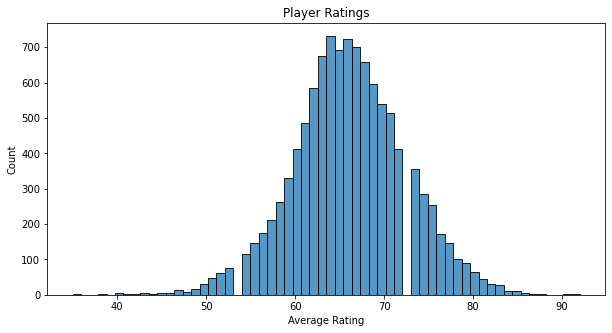

In [19]:
plt.figure(figsize=(10,5))
plt.title('Player Ratings')
sns.histplot(data = ratings['avg_rating'], bins=60)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

## Are more players right footed than left footed? Is there a difference between right/left footedness rankings?

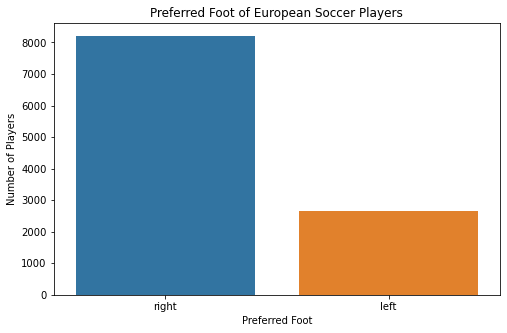

In [20]:
counts = ratings['pf_foot'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x= counts.index, y = counts,data = pd.DataFrame(counts))
plt.xlabel('Preferred Foot')
plt.ylabel('Number of Players')
plt.title('Preferred Foot of European Soccer Players')
plt.show()

More players as are predominantly right-footed as expected

In [23]:
left_ratings = query('''
SELECT avg_rating FROM 
(SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name) WHERE pf_foot = 'left'
''')

right_ratings = query('''
SELECT avg_rating FROM 
(SELECT pl.player_name as name, pa.preferred_foot as pf_foot, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name) WHERE pf_foot = 'right'
''')

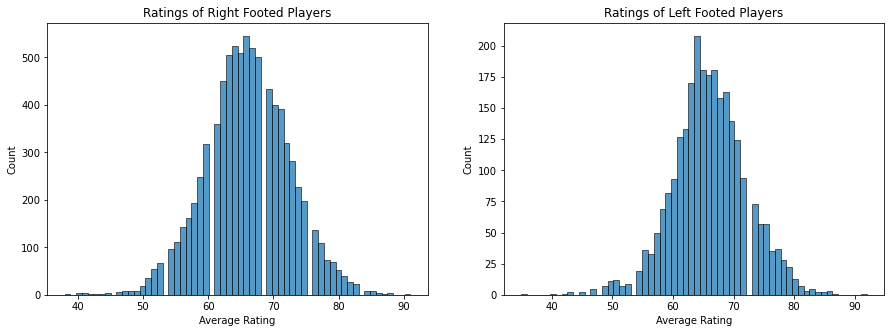

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Ratings of Right Footed Players')
sns.histplot(data = right_ratings['avg_rating'], bins=60)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.subplot(1,2,2)
plt.title('Ratings of Left Footed Players')
sns.histplot(data = left_ratings['avg_rating'], bins=60)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

In [27]:
np.median(right_ratings) == np.median(left_ratings)

True

Not only is the median rating of left and right footed players the same, their distributions look similar too!

## Trend in games with goals scored with headers

In [31]:
header_goals = query(
'''
SELECT season, 1.0*COUNT(goal)/(SELECT COUNT(*) FROM MATCH GROUP BY season) as goals 
FROM Match 
WHERE goal LIKE '%header%'
GROUP BY season
''')

In [32]:
header_goals

,season,goals
0,2008/2009,0.099519
1,2009/2010,0.113049
2,2010/2011,0.120265
3,2011/2012,0.118761
4,2012/2013,0.043897
5,2013/2014,0.040589
6,2014/2015,0.204149
7,2015/2016,0.235117


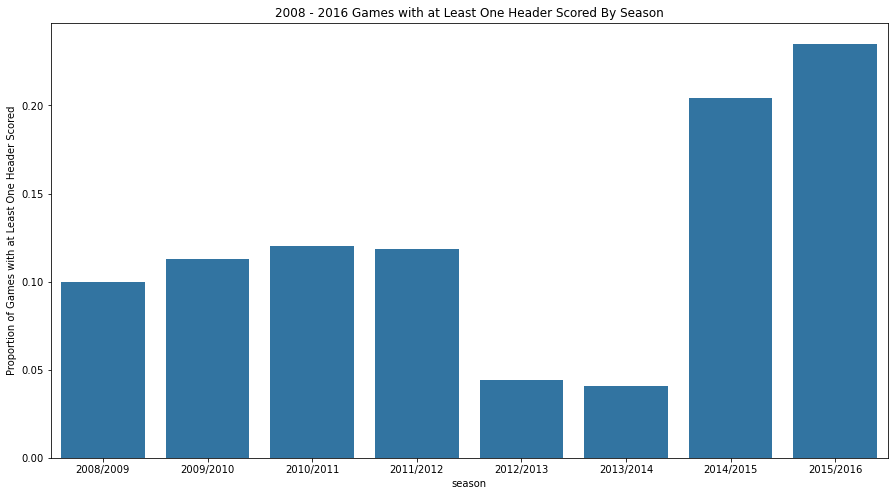

In [35]:
plt.figure(figsize=(15,8))
sns.barplot(x = 'season', y='goals', data = header_goals, color = sns.color_palette()[0])
plt.ylabel('Proportion of Games with at Least One Header Scored')
plt.title('2008 - 2016 Games with at Least One Header Scored By Season')
plt.show()

2012/2013 and 2013/2014 saw a drastic decline in the goals scored by headers, however, there was a significant jump in the proportion of header goals the next two seasons

## Relationship between player heoght and weight

In [58]:
height_and_weight = query('''
SELECT pl.player_name as name, pl.height, pl.weight, SUM(overall_rating)/COUNT(*) as avg_rating
FROM PLAYER as pl
JOIN PLAYER_ATTRIBUTES AS pa
ON pa.player_api_id = pl.player_api_id
GROUP BY pl.player_name
''')

height_and_weight

,name,height,weight,avg_rating
0,Aaron Appindangoye,182.88,187,63
1,Aaron Cresswell,170.18,146,66
2,Aaron Doran,170.18,163,67
3,Aaron Galindo,182.88,198,69
4,Aaron Hughes,182.88,154,73
...,...,...,...,...
10843,Zsolt Low,180.34,154,67
10844,Zurab Khizanishvili,185.42,172,70
10845,Zvjezdan Misimovic,180.34,176,80
10846,de Oliveira Cleber Monteiro,182.88,170,66


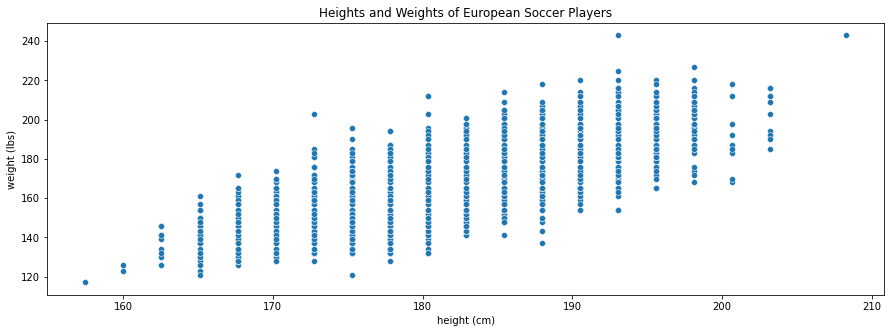

In [71]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=height_and_weight, x = 'height', y = 'weight')
plt.xlabel('height (cm)')
plt.ylabel('weight (lbs)')
plt.title('Heights and Weights of European Soccer Players')
plt.show()

In [63]:
height_and_weight[height_and_weight["height"] == height_and_weight['height'].max()]

,name,height,weight,avg_rating
5788,Kristof van Hout,208.28,243,61


Tallest player within the period was Kristof van Hout with a height of 208.28cm

In [64]:
height_and_weight[height_and_weight["weight"] == height_and_weight['weight'].max()]

,name,height,weight,avg_rating
5788,Kristof van Hout,208.28,243,61
10092,Tim Wiese,193.04,243,77


Heaviest players were Tim Wiese and Kristof van Hout at 243lbs each

In [68]:
height_and_weight[height_and_weight["height"] == height_and_weight['height'].min()]

,name,height,weight,avg_rating
5345,Juan Quero,157.48,117,66


Shortest player is Juan Quero at 157.48cm

In [69]:
height_and_weight[height_and_weight["weight"] == height_and_weight['weight'].min()]

,name,height,weight,avg_rating
5345,Juan Quero,157.48,117,66


Juan Quero is also the lightest player in terms of weight at 117lbs

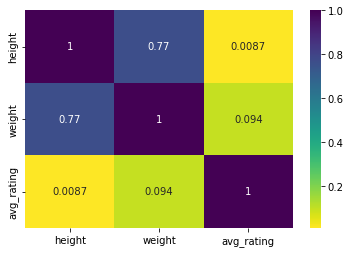

In [75]:
sns.heatmap(height_and_weight.corr(), cmap='viridis_r',annot=True);

There's a pretty high correlation between height and weight of European players. However, neither height nor weight seems to directly affect player's ratings.